In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 20.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438493 sha256=87c937b0221ac4bd3e79ad1a3b5d74a54a434302a9934c094620227a700f75d8
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [ ]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 20

In [ ]:
comm = MPI.COMM_WORLD

In [ ]:
%%writefile bif_map_funcs.py
import numpy as np

def bifurcation_map(x0, r, n=200):
    x_arr = np.array([x0])
    for _ in np.arange(n-1):
        x_1 = r * x_arr[-1] * (1 - x_arr[-1])
        x_arr = np.append(x_arr, x_1)
    return x_arr

def bif_map_4_r(x0, r, k=0, n=200):
    assert isinstance(r, (list, tuple, set, np.ndarray))
    assert k <= n
    
    arr_xri = bifurcation_map(x0, r[0], n)[-int(k):]
    for r_i in r[1:]:
        x_ri = bifurcation_map(x0, r_i, n)
        arr_xri = np.vstack([arr_xri, x_ri[-int(k):]])

    arr_xri = np.insert(arr_xri, 0,  r, 1)
    return arr_xri

#def dict_stuck(dict_1, dict_2):
#    assert isinstance(dict_1, dict)
#    assert isinstance(dict_2, dict)
#    res = {}
#    res.update(dict_1)
#    return res.update(dict_2)

Writing bif_map_funcs.py


In [ ]:
%%writefile parallel_bif_map.py

from mpi4py import MPI
import numpy as np
from bif_map_funcs import *
import matplotlib.pyplot as plt
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

mpi_wall_t = MPI.Wtime()
calc_t = time.time()

n = 2000    # Total number of iterations
k = 200     # Number of last iterations to use
x0 = np.random.uniform(0, 1)

r_space = np.linspace(-2, 4, 840)
r_per_rank = np.split(r_space, size)
r_subspace = r_per_rank[rank]

arr_rank = bif_map_4_r(x0, r_subspace, k, n)
calc_t = time.time() - calc_t

gather_t = time.time()
result_arr = comm.gather(arr_rank, root=0)
gather_t = time.time() - gather_t

mpi_wall_t = MPI.Wtime() - mpi_wall_t

if rank == 0:
    result_arr = np.concatenate(result_arr, 0)
    np.savez('result_' + str(size) + '.npz', arr_0=result_arr,
             calc_t=calc_t, gather_t=gather_t, mpi_wall_t=mpi_wall_t)

Writing parallel_bif_map.py


In [ ]:
!mpirun --allow-run-as-root -n 1 python parallel_bif_map.py

In [ ]:
!mpirun --allow-run-as-root -n 2 python parallel_bif_map.py

In [ ]:
!mpirun --allow-run-as-root -n 3 python parallel_bif_map.py

In [ ]:
!mpirun --allow-run-as-root -n 4 python parallel_bif_map.py

In [ ]:
!mpirun --allow-run-as-root -n 5 python parallel_bif_map.py

In [ ]:
!mpirun --allow-run-as-root -n 6 python parallel_bif_map.py

In [ ]:
!mpirun --allow-run-as-root -n 7 python parallel_bif_map.py

Calculation time: 9.752538204193115
Gather time: 0.0016298294067382812
Mpi Wall time: 9.754175886000013


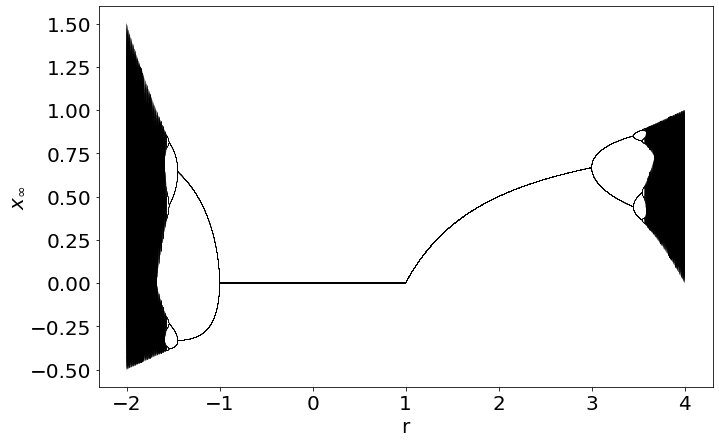

In [ ]:
k = 200
source = np.load('result_3.npz')
arr_ = source['arr_0']
calc_t = source['calc_t']
gather_t = source['gather_t']
mpi_wall_t = source['mpi_wall_t']

print(f'Calculation time: {calc_t}')
print(f'Gather time: {gather_t}')
print(f'Mpi Wall time: {mpi_wall_t}')

plt.plot([[r] * k for r in arr_[:, 0]], arr_[:, 1:], 'k', lw=.1)
plt.xlabel('r')
plt.ylabel('$x_{\infty}$');

## Speedup

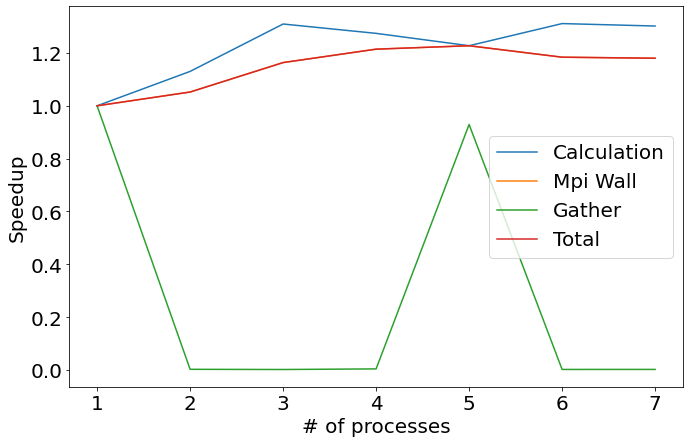

In [ ]:
k = 200

calc_t = np.array([])
gather_t = np.array([])
mpi_wall_t = np.array([])

for i in range(1, 8):
    source = np.load('result_' + str(i) + '.npz')
    calc_t = np.append(calc_t, source['calc_t'])
    gather_t = np.append(gather_t, source['gather_t'])
    mpi_wall_t = np.append(mpi_wall_t, source['mpi_wall_t'])
total_t = calc_t + gather_t

_, axes = plt.subplots(1, 1, figsize=(11, 7))

axes.plot(range(1, 8), calc_t[0] / calc_t, label='Calculation')
axes.plot(range(1, 8), mpi_wall_t[0] / mpi_wall_t, label='Mpi Wall')
axes.plot(range(1, 8), gather_t[0] / gather_t, label='Gather')
axes.plot(range(1, 8), total_t[0] / total_t, label='Total')

axes.set_xlabel('# of processes')
axes.set_ylabel('Speedup')
axes.legend()

# axes[1].set_xlabel('# of processes')
# axes[1].set_ylabel('Speedup')
# axes[1].legend();

## Speedup 2.0

In [ ]:
t_1 = time.time()
!mpirun --allow-run-as-root -n 1 python parallel_bif_map.py
t_1 = time.time() - t_1

In [ ]:
t_2 = time.time()
!mpirun --allow-run-as-root -n 2 python parallel_bif_map.py
t_2 = time.time() - t_2

In [ ]:
t_3 = time.time()
!mpirun --allow-run-as-root -n 3 python parallel_bif_map.py
t_3 = time.time() - t_3

In [ ]:
t_4 = time.time()
!mpirun --allow-run-as-root -n 4 python parallel_bif_map.py
t_4 = time.time() - t_4

In [ ]:
t_5 = time.time()
!mpirun --allow-run-as-root -n 5 python parallel_bif_map.py
t_5 = time.time() - t_5

In [ ]:
t_6 = time.time()
!mpirun --allow-run-as-root -n 6 python parallel_bif_map.py
t_6 = time.time() - t_6

In [ ]:
t_7 = time.time()
!mpirun --allow-run-as-root -n 7 python parallel_bif_map.py
t_7 = time.time() - t_7

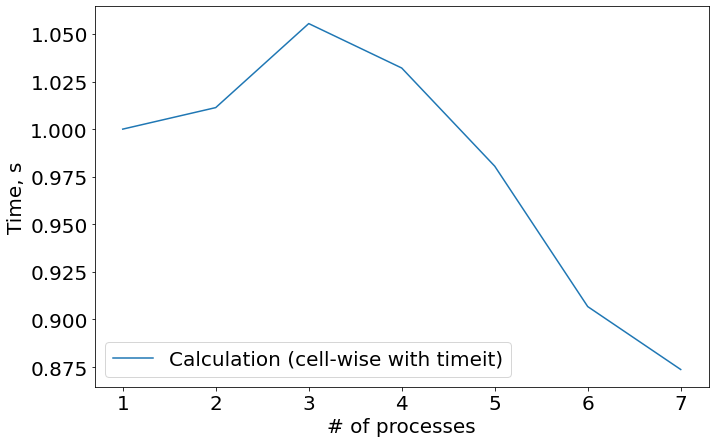

In [ ]:
plt.plot(range(1, 8), t_1 / np.array([t_1, t_2, t_3, t_4, t_5, t_6, t_7]), label='Calculation (cell-wise with timeit)')

plt.xlabel('# of processes')
plt.ylabel('Time, s')
plt.legend();